In [2]:
import json
import glob
import os
from PIL import Image
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from string import Template
import math
from uuid import uuid4 as uuid


In [3]:
def get_id():
    return str(uuid()).replace('-', '')

def find_json_files(dir_path):
    return glob.glob(os.path.join(dir_path, '*.json'))


def load_json_file(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def find_image_files(dir_path):
    """
    find all image files in the directory, including png, jpg, jpeg, etc.
    """
    return [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

def load_image_file(file_path):
    return Image.open(file_path).convert('RGB')


def plot_instruction_data(task):
    """
    plot the instruction data, including the image and the instruction
    """
    def plot_arrow(start, end):
        plt.arrow(start[0], start[1], end[0], end[1], head_width=50, head_length=50, fc='red', ec='red')

    def plot_cross(x, y):
        # Draw black outline
        plt.plot(x, y, 'X', color='blue', markersize=12, linewidth=3)
        # Draw white inner cross
        plt.plot(x, y, 'x', color='red', markersize=10, linewidth=1.5)

    def plot_rect(x1,y1,x2,y2):
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none', alpha=0.3)
        plt.gca().add_patch(rect)

    def plot_one_step(step):
        image_path = image_basename2path[step['image_path']]
        image = load_image_file(image_path)
        plt.imshow(image)
        t = f"Step ID: {step['step_id']}\nAction: {step['action']}"
        if step['action'] == 'TAP':
            plot_cross(step['touch_coord'][0], step['touch_coord'][1])
        elif step['action'] == 'SWIPE':
            plot_arrow(step['touch_coord'], step['lift_coord'])
        elif step['action'] == 'TYPE':
            t += "\nText: " + step['type_text']
        elif step['interest_region'] != [[0, 0], [0, 0]]:
            plot_rect(step['interest_region'][0][0], step['interest_region'][0][1], step['interest_region'][1][0], step['interest_region'][1][1])
        
        plt.title(t)
        plt.show()
    
    instruction = task['instruction']
    print("Episode: ", task['episode_id'], "step number: ", len(task['steps']))
    print("Instruction: ", instruction)
    
    for step in task['steps']:
        plot_one_step(step)
    
def add_element_data_into_task_data(task_data, image_path2element_data):
    for task in tqdm(task_data):
        for step in task['steps']:
            image_path = step['image_path']
            if image_path in image_path2element_data:
                step['element_data'] = image_path2element_data[image_path]
            else:
                step['element_data'] = None
    return task_data

def plot_element_data(element_data):
    def plot_rect(x1,y1,x2,y2, ax, color='r', alpha=0.1):
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor=color, facecolor='none', alpha=alpha)
        ax.add_patch(rect)

    page_caption = element_data.get('page_caption', 'None')
    print("Page caption: ", page_caption)
    image_path = image_basename2path.get(element_data.get('image_path', ""))
    assert image_path is not None, "image_path is None"
    image = load_image_file(image_path)
    clickable_elements = element_data.get('clickable_elements', [])
    scrollable_elements = element_data.get('scrollable_elements', [])
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image)
    ax[0].set_title('clickable bbox')
    ax[1].imshow(image)
    ax[1].set_title('scrollable bbox')
    for el in clickable_elements:
        x1, y1, x2, y2 = el['bbox']
        plot_rect(x1, y1, x2, y2, ax[0], color='r', alpha=1)
    for el in scrollable_elements:
        x1, y1, x2, y2 = el['bbox']
        plot_rect(x1, y1, x2, y2, ax[1], color='blue', alpha=1)
    plt.show()

def make_long_cot_template(task_data):
    """
    make a long cot template for the task data
    """
    action_spaces = """
    <Action>
        <Name>
            SWIPE
        </Name>
        <Description>
            Swipe in direction
        </Description>
        <Parameters>
            <Parameter>
                direction: left, right, up, down
            </Parameter>
        </Parameters>
    </Action>
    <Action>
        <Name>
            TAP
        </Name>
        <Description>
            Tap on the target element
        </Description>
        <Parameters>
            <Parameter>
                point: [x, y]
            </Parameter>
        </Parameters>
    </Action>
    <Action>
        <Name>
            TYPE
        </Name>
        <Description>
            Type the text in the text field
        </Description>
        <Parameters>
            <Parameter>
                text: the text to type
            </Parameter>
        </Parameters>
    </Action>
    <Action>
        <Name>
            TASK_COMPLETE
        </Name>
    </Action>
    <Action>
        <Name>
            PRESS_ENTER
        </Name>
    </Action>
    <Action>
        <Name>
            TASK_IMPOSSIBLE
        </Name>
    </Action>
    <Action>
        <Name>
            PRESS_BACK
        </Name>
    </Action>
    <Action>
        <Name>
            PRESS_HOME
        </Name>
    </Action>
    """
    template = Template("""
Please reason step by step, and put your final answer within <Answer>...</Answer>. Only output one step action at a time based on the given current screenshot content.
                        
The final answer format must follow like this:
<Answer>
    <Action Description>
        In this step, I will click the play button to start the video.
    </Action Description>
    <Action>
        <Name>
            TAP
        </Name>
        <Parameters>
            <Parameter>
                point: [x, y]
            </Parameter>
        </Parameters>
    </Action>
</Answer>

Here is the task:
<Task>
    $instruction
</Task>

Here is the current screenshot content description:
<Current screenshot content>
    $current_screenshot_content
</Current screenshot content>
                        
Here is the previous action:
<Previous Action>
    $previous_action
</Previous Action>

Here is the action space:
<ActionSpace>
    $action_spaces
</ActionSpace>
""")
    def normalize_bbox(bbox, width, height):
        x1, y1, x2, y2 = bbox
        return [int(x1 / width * 999), int(y1 / height * 999), int(x2 / width * 999), int(y2 / height * 999)]
    
    def normalize_point(point, width, height):
        x, y = point
        return [int(x / width * 999), int(y / height * 999)]
    
    def format_element_data2screenshot_content(element_data, width, height):
        clickable_elements = element_data.get('clickable_elements', [])
        # scrollable_elements = element_data.get('scrollable_elements', [])
        screenshot_content = []
        for idx, el in enumerate(clickable_elements):
            screenshot_content.append(f"Clickable element {idx}; xml description:{el['xml_desc']}, bbox: {normalize_bbox(el['bbox'], width, height)}, functionality: {el.get('functionality', '')}") # output the bbox in normalized range [0, 999]
        return "\n".join(screenshot_content)
    
    def format_action(step):
        action_name = step['action']
        touch_coord = step['touch_coord']
        lift_coord = step['lift_coord']
        clickable_elements = step['element_data']['clickable_elements']
        width, height = step['device_dim']

        action_output = Template("""
    <Answer>
        <Action Description>
            $action_description
        </Action Description>
        <Action>
            <Name>
                $action_name
            </Name>
            <Parameters>
                <Parameter>
                    $action_parameters
                </Parameter>
            </Parameters>
        </Action>
    </Answer>""")    
        action_output_wo_param = Template("""
    <Answer>
        <Action Description>
            $action_description
        </Action Description>
        <Action>
            <Name>
                $action_name
            </Name>
        </Action>
    </Answer>""")
        
        
        def find_active_element(touch_coord, clickable_elements):
            # all coordinates are in the original scale, no normalization
            candidate_elements = []
            for el in clickable_elements:
                x1, y1, x2, y2 = el['bbox']
                if x1 <= touch_coord[0] <= x2 and y1 <= touch_coord[1] <= y2:
                    candidate_elements.append(el)
            if len(candidate_elements) == 0:
                return None 
            elif len(candidate_elements) == 1:
                return candidate_elements[0]
            else:
                # TODO: 直接给出最小的 bbox 元素
                return sorted(candidate_elements, key=lambda x: (x['bbox'][2] - x['bbox'][0]) * (x['bbox'][3] - x['bbox'][1]))[0]
        
        def find_swipe_direction(touch_coord, lift_coord):
            # all coordinates are in the original scale, no normalization
            """
            touch_coord 是触控起点坐标，lift_coord 是触控终点坐标， 以 touch_coord 为原点，计算向量 lift_coord - touch_coord和 x 轴方向的夹角 a
            left: a 在 [0,30],[330,360] 度之间
            up: a 在 [30,150] 度之间
            right: a 在 [150,210] 度之间
            down: a 在 [210,330] 度之间
            """
            vector = [lift_coord[0] - touch_coord[0], lift_coord[1] - touch_coord[1]]
            a = math.atan2(vector[1], vector[0]) * 180 / math.pi
            # Convert from [-180, 180] to [0, 360]
            a = (a + 360) % 360
            if 0 <= a <= 30 or 330 <= a <= 360: 
                return "left"
            elif 30 <= a <= 150:
                return "up"
            elif 150 <= a <= 210:
                return "right"
            elif 210 <= a <= 330:
                return "down"
            else:
                raise ValueError(f"swipe direction not found for {touch_coord} and {lift_coord}")
            
        def format_tap_description(active_element):
            if active_element.get("xml_desc"):
                if active_element.get("functionality"):
                    return f"Click on the {active_element['xml_desc']} to ({active_element['functionality']})"
                else:
                    return f"Click on the {active_element['xml_desc']}"
            else:
                return f"Click on the element in the active region {normalize_bbox(active_element['bbox'], width, height)}" # output the bbox in normalized range [0, 999]

        if action_name == 'TAP':
            assert touch_coord is not None and touch_coord == lift_coord, "touch_coord and lift_coord must be the same for TAP action"
            active_element = find_active_element(touch_coord, clickable_elements)
            if active_element is None:
                return action_output.substitute(action_name=action_name, action_parameters=f"point: {normalize_point(touch_coord, width, height)}", action_description="")
            else:
                return action_output.substitute(action_name=action_name, action_parameters=f"point: {normalize_point(touch_coord, width, height)}", action_description=format_tap_description(active_element))
        
        elif action_name == 'SWIPE':
            assert touch_coord is not None and lift_coord is not None, "touch_coord and lift_coord must be exist for SWIPE action"
            direction = find_swipe_direction(touch_coord, lift_coord)
            return action_output.substitute(action_name=action_name, action_parameters=f"direction: {direction}", action_description=f"Swipe {direction}")
        
        elif action_name == 'TYPE':
            # assert step['type_text'], "type_text must be exist for TYPE action"
            if step['type_text'] is None:
                print(step)
                return action_output.substitute(action_name=action_name, action_parameters=f"text: ", action_description=f"Type ")
            return action_output.substitute(action_name=action_name, action_parameters=f"text: {step['type_text']}", action_description=f"Type {step['type_text']}")
        
        elif action_name == 'TASK_COMPLETE':
            return action_output_wo_param.substitute(action_name=action_name, action_description="Task complete")
        elif action_name == 'TASK_IMPOSSIBLE':
            return action_output_wo_param.substitute(action_name=action_name, action_description="Task impossible")
        elif action_name == 'PRESS_ENTER':
            return action_output_wo_param.substitute(action_name=action_name, action_description="Press enter")
        elif action_name == 'PRESS_BACK':
            return action_output_wo_param.substitute(action_name=action_name, action_description="Press back")
        elif action_name == 'PRESS_HOME':
            return action_output_wo_param.substitute(action_name=action_name, action_description="Press home")
        else:
            return action_output_wo_param.substitute(action_name=action_name, action_description=f"{action_name} action")
                
    step_prompts = []
    step_actions = []
    for step in task_data['steps']:
        instruction = task_data['instruction']
        current_screenshot_element_data = step['element_data']
        width, height = step['device_dim']
        current_screenshot_content = format_element_data2screenshot_content(current_screenshot_element_data, width, height)
        current_action = format_action(step)
        step_actions.append(current_action)
        step_prompts.append(template.substitute(instruction=instruction, current_screenshot_content=current_screenshot_content, previous_action="\n".join(step_actions[:-1]), action_spaces=action_spaces))
    
    return step_prompts, step_actions

def generate_prompt_dataset(task_data):
    """
    Generate prompt dataset for PPO model
    jsonl file with 3 fields: problem, image, solution
    """
    action_spaces = """
    <action>
        <name>
            SWIPE
        </name>
        <description>
            Swipe in direction
        </description>
        <parameters>
            <parameter>
                direction: left|right|up|down
            </parameter>
        </parameters>
    </action>
    <action>
        <name>
            TAP
        </name>
        <description>
            Tap on the target element
        </description>
        <parameters>
            <parameter>
                point: [x, y]
            </parameter>
        </parameters>
    </action>
    <action>
        <name>
            TYPE
        </name>
        <description>
            Input text in the text field
        </description>
        <parameters>
            <parameter>
                text: the text to type
            </parameter>
        </parameters>
    </action>
    <action>
        <name>
            TASK_COMPLETE
        </name>
        <description>
            Task is completed
        </description>
    </action>
    <action>
        <name>
            PRESS_ENTER
        </name>
        <description>
            Press enter key
        </description>
    </action>
    <action>
        <name>
            TASK_IMPOSSIBLE
        </name>
        <description>
            Task is impossible
        </description>
    </action>
    <action>
        <name>
            PRESS_BACK
        </name>
        <description>
            Press back key
        </description>
    </action>
    <action>
        <name>
            PRESS_HOME
        </name>
        <description>
            Press home key
        </description>
    </action>
    <action>
        <name>
            WAIT
        </name>
        <description>
            Wait for a while
        </description>
    </action>
    """
    template = Template("""
    Given the task:
    <task>
        $instruction
    </task>
    
    You have to take one action from the following action space:
    <action_space>
        $action_spaces
    </action_space>

    And here is the previous action had been taken:
    <previous action>
        $previous_action
    </previous action>

    Remember the final answer format must follow like this:
    <answer>
        <action description>
            In this step, I will click the play button to start the video.
        </action description>
        <action>
            <name>
                TAP
            </name>
            <parameters>
                <parameter>
                    point: [x, y]
                </parameter>
            </parameters>
        </action>
    </answer>
    
    Give the next action and only one action at a time.
""")
    
    def normalize_bbox(bbox, width, height):
        x1, y1, x2, y2 = bbox
        return [int(x1 / width * 999), int(y1 / height * 999), int(x2 / width * 999), int(y2 / height * 999)]
    
    def normalize_point(point, width, height):
        x, y = point
        return [int(x / width * 999), int(y / height * 999)]
    
    def format_action(step):
        action_name = step['action']
        touch_coord = step['touch_coord']
        lift_coord = step['lift_coord']
        clickable_elements = step['element_data']['clickable_elements']
        width, height = step['device_dim']

        action_output = Template("""
    <answer>
        <action description>
            $action_description
        </action description>
        <action>
            <name>
                $action_name
            </name>
            <parameters>
                <parameter>
                    $action_parameters
                </parameter>
            </parameters>
        </action>
    </answer>""")   
        tap_action_output_with_active_region = Template("""
    <answer>
        <action description>
            $action_description
        </action description>
        <action>
            <name>
                $action_name
            </name>
            <parameters>
                <parameter>
                    $action_parameters
                </parameter>
            </parameters>
        </action>
        <active region>
            region: $active_region
        </active region>
    </answer>""")
         
        action_output_wo_param = Template("""
    <answer>
        <action description>
            $action_description
        </action description>
        <action>
            <name>
                $action_name
            </name>
        </action>
    </answer>""")
        
        
        
        def find_active_element(touch_coord, clickable_elements):
            # all coordinates are in the original scale, no normalization
            candidate_elements = []
            for el in clickable_elements:
                x1, y1, x2, y2 = el['bbox']
                if x1 <= touch_coord[0] <= x2 and y1 <= touch_coord[1] <= y2:
                    candidate_elements.append(el)
            if len(candidate_elements) == 0:
                return None 
            elif len(candidate_elements) == 1:
                return candidate_elements[0]
            else:
                # TODO: 直接给出最小的 bbox 元素
                return sorted(candidate_elements, key=lambda x: (x['bbox'][2] - x['bbox'][0]) * (x['bbox'][3] - x['bbox'][1]))[0]
        
        def find_swipe_direction(touch_coord, lift_coord):
            # all coordinates are in the original scale, no normalization
            """
            touch_coord 是触控起点坐标，lift_coord 是触控终点坐标， 以 touch_coord 为原点，计算向量 lift_coord - touch_coord和 x 轴方向的夹角 a
            left: a 在 [0,30],[330,360] 度之间
            up: a 在 [30,150] 度之间
            right: a 在 [150,210] 度之间
            down: a 在 [210,330] 度之间
            """
            vector = [lift_coord[0] - touch_coord[0], lift_coord[1] - touch_coord[1]]
            a = math.atan2(vector[1], vector[0]) * 180 / math.pi
            # Convert from [-180, 180] to [0, 360]
            a = (a + 360) % 360
            if 0 <= a <= 30 or 330 <= a <= 360: 
                return "left"
            elif 30 <= a <= 150:
                return "up"
            elif 150 <= a <= 210:
                return "right"
            elif 210 <= a <= 330:
                return "down"
            else:
                raise ValueError(f"swipe direction not found for {touch_coord} and {lift_coord}")
            
        def format_tap_description(active_element):
            if active_element.get("xml_desc"):
                if active_element.get("functionality"):
                    return f"Click on the {active_element['xml_desc']} to ({active_element['functionality']})"
                else:
                    return f"Click on the {active_element['xml_desc']}"
            else:
                return f"Click on the element in the active region {normalize_bbox(active_element['bbox'], width, height)}" # output the bbox in normalized range [0, 999]

        if action_name == 'TAP':
            assert touch_coord is not None and touch_coord == lift_coord, "touch_coord and lift_coord must be the same for TAP action"
            active_element = find_active_element(touch_coord, clickable_elements)
            if active_element is None:
                return action_output.substitute(action_name=action_name, action_parameters=f"point: {normalize_point(touch_coord, width, height)}", action_description=""), \
                    action_output.substitute(action_name=action_name, action_parameters=f"point: {normalize_point(touch_coord, width, height)}", action_description="")
            else:
                return action_output.substitute(action_name=action_name, action_parameters=f"point: {normalize_point(touch_coord, width, height)}", action_description=format_tap_description(active_element)), \
                    tap_action_output_with_active_region.substitute(action_name=action_name, action_parameters=f"point: {normalize_point(touch_coord, width, height)}", action_description=format_tap_description(active_element), active_region=normalize_bbox(active_element['bbox'], width, height))
        
        elif action_name == 'SWIPE':
            assert touch_coord is not None and lift_coord is not None, "touch_coord and lift_coord must be exist for SWIPE action"
            direction = find_swipe_direction(touch_coord, lift_coord)
            return action_output.substitute(action_name=action_name, action_parameters=f"direction: {direction}", action_description=f"Swipe {direction}"), \
                action_output.substitute(action_name=action_name, action_parameters=f"direction: {direction}", action_description=f"Swipe {direction}")
        
        elif action_name == 'TYPE':
            # assert step['type_text'], "type_text must be exist for TYPE action"
            if step['type_text'] is None:
                print(step)
                return action_output.substitute(action_name=action_name, action_parameters=f"text: ", action_description=f"Type "), \
                    action_output.substitute(action_name=action_name, action_parameters=f"text: ", action_description=f"Type ")
            return action_output.substitute(action_name=action_name, action_parameters=f"text: {step['type_text']}", action_description=f"Type {step['type_text']}"), \
                action_output.substitute(action_name=action_name, action_parameters=f"text: {step['type_text']}", action_description=f"Type {step['type_text']}")
        
        elif action_name == 'TASK_COMPLETE':
            return action_output_wo_param.substitute(action_name=action_name, action_description="Task complete"), \
                action_output_wo_param.substitute(action_name=action_name, action_description="Task complete")
        elif action_name == 'TASK_IMPOSSIBLE':
            return action_output_wo_param.substitute(action_name=action_name, action_description="Task impossible"), \
                action_output_wo_param.substitute(action_name=action_name, action_description="Task impossible")
        elif action_name == 'PRESS_ENTER':
            return action_output_wo_param.substitute(action_name=action_name, action_description="Press enter"), \
                action_output_wo_param.substitute(action_name=action_name, action_description="Press enter")
        elif action_name == 'PRESS_BACK':
            return action_output_wo_param.substitute(action_name=action_name, action_description="Press back"), \
                action_output_wo_param.substitute(action_name=action_name, action_description="Press back")
        elif action_name == 'PRESS_HOME':
            return action_output_wo_param.substitute(action_name=action_name, action_description="Press home"), \
                action_output_wo_param.substitute(action_name=action_name, action_description="Press home")
        else:
            return action_output_wo_param.substitute(action_name=action_name, action_description=f"{action_name} action"), \
                action_output_wo_param.substitute(action_name=action_name, action_description=f"{action_name} action")
                
    
    prompt_dataset = []
    for task in task_data:
        instruction = task['instruction']
        step_prompts = []
        gt_step_actions = []
        step_actions = []
        for step in task['steps']:
            action, gt_action = format_action(step)
            step_prompts.append(template.substitute(instruction=instruction, previous_action="\n".join(step_actions[-2:-1]), action_spaces=action_spaces)) # limit the previous action to 1/0 step
            step_actions.append(action)
            gt_step_actions.append(gt_action)
            
            prompt_dataset.append({
                "problem": step_prompts[-1],
                "image_path": image_basename2path.get(step['image_path']),
                "solution": gt_action
            })
    return prompt_dataset


In [12]:
def normalize_bbox(bbox, width, height):
    x1, y1, x2, y2 = bbox
    return [int(x1 / width * 999), int(y1 / height * 999), int(x2 / width * 999), int(y2 / height * 999)]

def normalize_point(point, width, height):
    x, y = point
    return [int(x / width * 999), int(y / height * 999)]

def format_element_data2screenshot_content(element_data, width, height):
    clickable_elements = element_data.get('clickable_elements', [])
    # scrollable_elements = element_data.get('scrollable_elements', [])
    screenshot_content = []
    for _, el in enumerate(clickable_elements):
        screenshot_content.append(f"Clickable element: xml description:{el['xml_desc']}, bbox: {normalize_bbox(el['bbox'], width, height)}, functionality: {el.get('functionality', '')}") # output the bbox in normalized range [0, 999]
    return "\n".join(screenshot_content)

def format_action(step):
    action_name = step['action']
    touch_coord = step['touch_coord']
    lift_coord = step['lift_coord']
    clickable_elements = step['element_data']['clickable_elements']
    width, height = step['device_dim']

    action_output_with_param = Template("""
<answer>
    <description>
        $action_description
    </description>
    <action>
        <action_name>
            $action_name
        </action_name>
        <parameters>
            <parameter>
                <param_name>
                    $param_name
                </param_name>
                <param_value>
                    $param_value
                </param_value>
            </parameter>
        </parameters>
    </action>
</answer>""")   
    tap_action_output_with_active_region = Template("""
<answer>
    <description>
        $action_description
    </description>
    <action>
        <action_name>
            $action_name
        </action_name>
        <parameters>
            <parameter>
                <param_name>
                    $param_name 
                </param_name>
                <param_value>
                    $param_value
                </param_value>
            </parameter>
        </parameters>
    </action>
    <active region>
        region: $active_region
    </active region>
</answer>""") 
    action_output_wo_param = Template("""
<answer>
    <description>
        $action_description
    </description>
    <action>
        <action_name>
            $action_name
        </action_name>
    </action>
</answer>""")
    
    def find_active_element(touch_coord, clickable_elements):
        # all coordinates are in the original scale, no normalization
        candidate_elements = []
        for el in clickable_elements:
            x1, y1, x2, y2 = el['bbox']
            if x1 <= touch_coord[0] <= x2 and y1 <= touch_coord[1] <= y2:
                candidate_elements.append(el)
        if len(candidate_elements) == 0:
            return None 
        elif len(candidate_elements) == 1:
            return candidate_elements[0]
        else:
            # TODO: 直接给出最小的 bbox 元素
            return sorted(candidate_elements, key=lambda x: (x['bbox'][2] - x['bbox'][0]) * (x['bbox'][3] - x['bbox'][1]))[0]
    
    def find_swipe_direction(touch_coord, lift_coord):
        # all coordinates are in the original scale, no normalization
        """
        touch_coord 是触控起点坐标，lift_coord 是触控终点坐标， 以 touch_coord 为原点，计算向量 lift_coord - touch_coord和 x 轴方向的夹角 a
        left: a 在 [0,30],[330,360] 度之间
        up: a 在 [30,150] 度之间
        right: a 在 [150,210] 度之间
        down: a 在 [210,330] 度之间
        """
        vector = [lift_coord[0] - touch_coord[0], lift_coord[1] - touch_coord[1]]
        a = math.atan2(vector[1], vector[0]) * 180 / math.pi
        # Convert from [-180, 180] to [0, 360]
        a = (a + 360) % 360
        if 0 <= a <= 30 or 330 <= a <= 360: 
            return "left"
        elif 30 <= a <= 150:
            return "up"
        elif 150 <= a <= 210:
            return "right"
        elif 210 <= a <= 330:
            return "down"
        else:
            raise ValueError(f"swipe direction not found for {touch_coord} and {lift_coord}")
        
    def format_tap_description(active_element):
        if active_element.get("xml_desc"):
            if active_element.get("functionality"):
                return f"Click on the {active_element['xml_desc']} to ({active_element['functionality']})"
            else:
                return f"Click on the {active_element['xml_desc']}"
        else:
            return f"Click on the element in the active region {normalize_bbox(active_element['bbox'], width, height)}" # output the bbox in normalized range [0, 999]

    if action_name == 'TAP':
        assert touch_coord is not None and touch_coord == lift_coord, "touch_coord and lift_coord must be the same for TAP action"
        active_element = find_active_element(touch_coord, clickable_elements)
        if active_element is None:
            return action_output_with_param.substitute(action_name=action_name, param_name="point", param_value=f"{normalize_point(touch_coord, width, height)}", action_description=""), \
                action_output_with_param.substitute(action_name=action_name, param_name="point", param_value=f"{normalize_point(touch_coord, width, height)}", action_description="")
        else:
            return action_output_with_param.substitute(action_name=action_name, param_name="point", param_value=f"{normalize_point(touch_coord, width, height)}", action_description=format_tap_description(active_element)), \
                tap_action_output_with_active_region.substitute(action_name=action_name, param_name="point", param_value=f"{normalize_point(touch_coord, width, height)}", action_description=format_tap_description(active_element), active_region=normalize_bbox(active_element['bbox'], width, height))
    
    elif action_name == 'SWIPE':
        assert touch_coord is not None and lift_coord is not None, "touch_coord and lift_coord must be exist for SWIPE action"
        direction = find_swipe_direction(touch_coord, lift_coord)
        return action_output_with_param.substitute(action_name=action_name, param_name="direction", param_value=f"{direction}", action_description=f"Swipe {direction}"), \
            action_output_with_param.substitute(action_name=action_name, param_name="direction", param_value=f"{direction}", action_description=f"Swipe {direction}")
    
    elif action_name == 'TYPE':
        # assert step['type_text'], "type_text must be exist for TYPE action"
        if step['type_text'] is None:
            print(step)
            return action_output_with_param.substitute(action_name=action_name, param_name="text", param_value=f" ", action_description=f"Type "), \
                action_output_with_param.substitute(action_name=action_name, param_name="text", param_value=f" ", action_description=f"Type ")
        return action_output_with_param.substitute(action_name=action_name,  param_name="text", param_value=f"{step['type_text']}", action_description=f"Type {step['type_text']}"), \
            action_output_with_param.substitute(action_name=action_name, param_name="text", param_value=f"{step['type_text']}", action_description=f"Type {step['type_text']}")
    
    elif action_name == 'TASK_COMPLETE':
        return action_output_wo_param.substitute(action_name=action_name, action_description="Task has been completed"), \
            action_output_wo_param.substitute(action_name=action_name, action_description="Task has been completed")
    elif action_name == 'TASK_IMPOSSIBLE':
        return action_output_wo_param.substitute(action_name=action_name, action_description="Task is impossible to achieve"), \
            action_output_wo_param.substitute(action_name=action_name, action_description="Task is impossible to achieve")
    elif action_name == 'PRESS_ENTER':
        return action_output_wo_param.substitute(action_name=action_name, action_description="Press enter key"), \
            action_output_wo_param.substitute(action_name=action_name, action_description="Press enter key")
    elif action_name == 'PRESS_BACK':
        return action_output_wo_param.substitute(action_name=action_name, action_description="Press back key"), \
            action_output_wo_param.substitute(action_name=action_name, action_description="Press back key")
    elif action_name == 'PRESS_HOME':
        return action_output_wo_param.substitute(action_name=action_name, action_description="Press home key"), \
            action_output_wo_param.substitute(action_name=action_name, action_description="Press home key")
    elif action_name == 'WAIT':
        return action_output_wo_param.substitute(action_name=action_name, action_description="Wait for a while"), \
            action_output_wo_param.substitute(action_name=action_name, action_description="Wait for a while")
    else:
        return action_output_wo_param.substitute(action_name=action_name, action_description=f"{action_name} action"), \
            action_output_wo_param.substitute(action_name=action_name, action_description=f"{action_name} action")

def generate_distill_data(task, prompt_templates:dict):
    prompt_data = []
    instruction = task['instruction']
    episode_id = task['episode_id']
    
    for step in task['steps']:
        step_id = step['step_id']
        step_index = f"{episode_id}_{step_id}"
        image_path = step['image_path']
        element_data = step['element_data']
        action, gt_action = format_action(step)
        width, height = step['device_dim']
        screenshot_content = format_element_data2screenshot_content(element_data, width, height)
        prompt = prompt_templates['prompt'].substitute(instruction=instruction, current_screenshot_layout=screenshot_content, action_spaces=prompt_templates['action_space'])
        prompt_data.append({
            "step_index": step_index,
            "image_path": image_path,
            "prompt": prompt,
            "gt_action": gt_action,
            "step": step
        })
    return prompt_data
        

In [13]:
action_space = """
<action>
    <action_name>
        SWIPE
    </action_name>
    <action_description>
        Swipe the screen in one direction
    </action_description>
    <parameters>
        <parameter>
            <param_name>
                direction
            </param_name>
            <param_description>
                the direction to swipe, only left, right, up, down are allowed
            </param_description>
        </parameter>
    </parameters>
</action>
<action>
    <action_name>
        TAP
    </action_name>
    <action_description>
        Tap the target element on the screen
    </action_description>
    <parameters>
        <parameter>
            <param_name>
                point
            </param_name>
            <param_description>
                the coordinates of the target element, [x, y], x and y are the coordinates of the target element on the screen, range from 0 to 999
            </param_description>
        </parameter>
    </parameters>
</action>
<action>
    <action_name>
        TYPE
    </action_name>
    <action_description>
        Type the text in the text input field
    </action_description>
    <parameters>
        <parameter>
            <param_name>
                text
            </param_name>
            <param_description>
                the text to input
            </param_description>
        </parameter>
    </parameters>
</action>
<action>
    <action_name>
        TASK_COMPLETE
    </action_name>
    <action_description>
        The task is completed based on the current state of the screen
    </action_description>
</action>
<action>
    <action_name>
        PRESS_ENTER
    </action_name>
    <action_description>
        Press the enter key on the keyboard
    </action_description>
</action>
<action>
    <action_name>
        TASK_IMPOSSIBLE
    </action_name>
    <action_description>
        The task is impossible to be completed based on the current state of the screen
    </action_description>
</action>
<action>
    <action_name>
        PRESS_BACK
    </action_name>
    <action_description>
        Press the back key on the keyboard
    </action_description>
</action>
<action>
    <action_name>
        PRESS_HOME
    </action_name>
    <action_description>
        Press the home key on the keyboard
    </action_description>
</action>
<action>
    <action_name>
        WAIT
    </action_name>
    <action_description>
        Wait for a while
    </action_description>
</action>
"""
prompt = Template("""
Please reason step by step, and put your final answer within <answer>...</answer>. Only output one step action at a time based on the given current screenshot content.
                        
The final answer format must follow like this:
<answer>
    <description>
        In this step, I will click the play button to start the video.
    </description>
    <action>
        <action_name>
            TAP
        </action_name>
        <parameters>
            <parameter>
                <param_name>
                    point
                </param_name>
                <param_value>
                    [100, 100]
                </param_value>
            </parameter>
        </parameters>
    </action>
</answer>

Here is the task:
<task>
    $instruction
</task>

Here is the current screenshot layout:
<current screenshot layout>
    $current_screenshot_layout
</current screenshot layout>

Here is the action space:
<action space>
    $action_spaces
</action space>
""")

prompt_templates = {
    "action_space": action_space,
    "prompt": prompt
}

data = []
for task in task_data:
    data.extend(generate_distill_data(task, prompt_templates))

with open('distill_data.jsonl', 'w') as f:
    for d in data:
        f.write(json.dumps(d, ensure_ascii=False)+"\n")


In [16]:
print(data[0]['prompt'])


Please reason step by step, and put your final answer within <answer>...</answer>. Only output one step action at a time based on the given current screenshot content.
                        
The final answer format must follow like this:
<answer>
    <description>
        In this step, I will click the play button to start the video.
    </description>
    <action>
        <action_name>
            TAP
        </action_name>
        <parameters>
            <parameter>
                <param_name>
                    point
                </param_name>
                <param_value>
                    [100, 100]
                </param_value>
            </parameter>
        </parameters>
    </action>
</answer>

Here is the task:
<task>
    Open TodayTix. Search "Lion King" in New York. Specify the date as May 7th. Want 3 tickets. Proceed to check ticket prices range.
</task>

Here is the current screenshot layout:
<current screenshot layout>
    Clickable element: xml description:

In [4]:
image_dir = '/data/true_nas/zfs_share1/zyc/data/data/Yuxiang007/AMEX/AMEX/screenshot'
element_anno_dir = '/data/true_nas/zfs_share1/zyc/data/data/Yuxiang007/AMEX/AMEX/element_anno'
task_anno_dir = '/data/true_nas/zfs_share1/zyc/data/data/Yuxiang007/AMEX/AMEX/instruction_anno'

task_anno_files = find_json_files(task_anno_dir)
task_data = []
for file in task_anno_files:
    task_data.append(load_json_file(file))

image_files = find_image_files(image_dir)
image_basename2path = {os.path.basename(path): path for path in image_files}

element_anno_files = find_json_files(element_anno_dir)
element_data = []
for file in tqdm(element_anno_files):
    element_data.append(load_json_file(file))
image_path2element_data = {}
for ed in element_data:
    image_path2element_data[ed['image_path']] = ed
print(f"Found {len(element_data)} element anno files, and get unique {len(image_path2element_data)} images annotations")

task_data = add_element_data_into_task_data(task_data, image_path2element_data)

100%|██████████| 104674/104674 [00:34<00:00, 3057.88it/s]


Found 104674 element anno files, and get unique 104674 images annotations


100%|██████████| 3046/3046 [00:00<00:00, 79787.73it/s]


In [9]:
# action data state
task_data[0]['steps'][0]

{'step_id': 1,
 'action': 'SWIPE',
 'touch_coord': [769, 2004],
 'lift_coord': [769, 962],
 'device_dim': [1440, 2960],
 'package_name': 'com.android.launcher3',
 'type_text': '',
 'need_human_check': False,
 'interest_region': [[0, 0], [0, 0]],
 'image_path': '2024_4_26_14_33_b0c1f08e53664926952ccc066864f075-1.png',
 'element_data': {'image_path': '2024_4_26_14_33_b0c1f08e53664926952ccc066864f075-1.png',
  'clickable_elements': [{'bbox': [53, 276, 197, 420],
    'xml_desc': [],
    'functionality': ''},
   {'bbox': [197, 283, 1373, 413], 'xml_desc': [], 'functionality': ''},
   {'bbox': [303, 2060, 581, 2549],
    'xml_desc': ['Gallery', 'Gallery'],
    'functionality': ''},
   {'bbox': [581, 2060, 859, 2549],
    'xml_desc': ['Chrome', 'Chrome'],
    'functionality': ''},
   {'bbox': [859, 2060, 1137, 2549],
    'xml_desc': ['Play Store', 'Play Store'],
    'functionality': ''},
   {'bbox': [25, 2624, 303, 2813],
    'xml_desc': ['Phone', 'Phone'],
    'functionality': ''},
   {'bbox

In [17]:
prompt_dataset = generate_prompt_dataset(task_data)

with open('prompt_dataset.jsonl', 'w') as f:
    for p in prompt_dataset:
        f.write(json.dumps(p, ensure_ascii=False)+"\n")

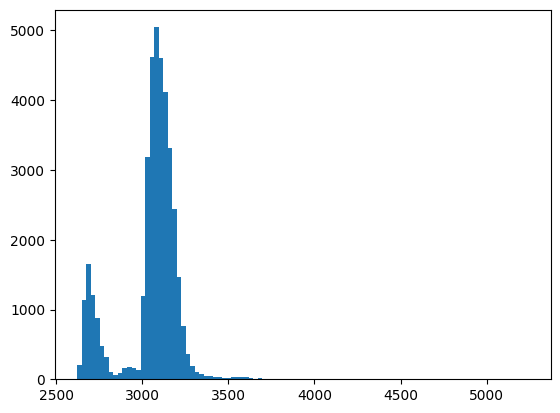

In [21]:
len_count = []
for p in prompt_dataset:
    len_count.append(len(p['problem']))
plt.hist(len_count, bins=100)
plt.show()

Page caption:  The screenshot displays a section of a mobile app focused on haircare products. It includes sorting and filtering options at the top, categories for different types of hair products, and a list of individual products with details such as brand, price, and size. Each product has options to view more details or perform actions like adding to favorites or cart.


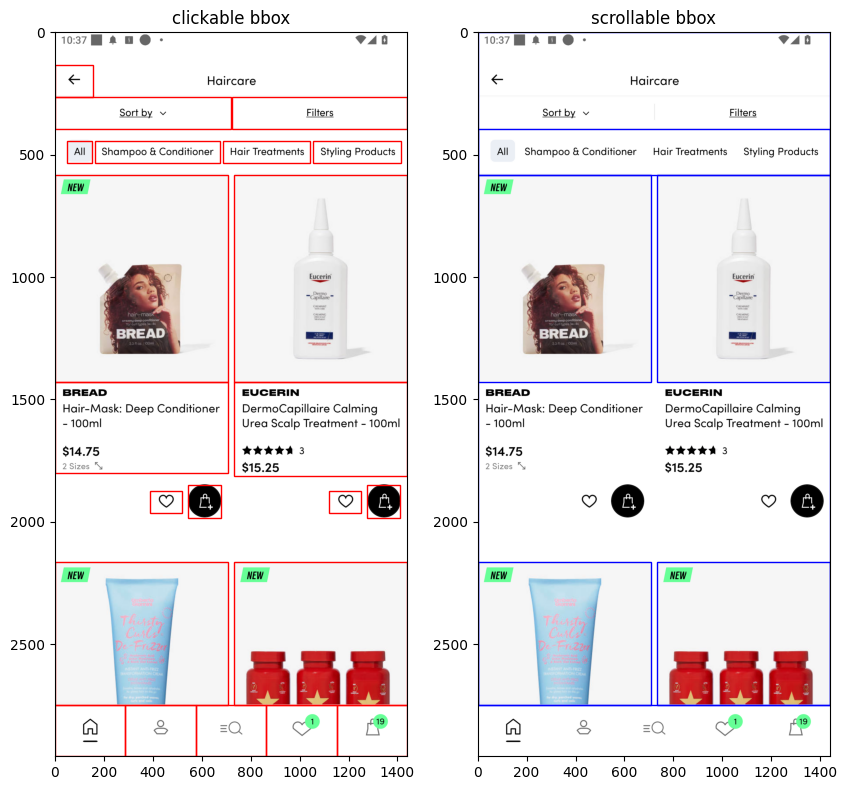

[{'bbox': [0, 0, 1440, 2750], 'xml_desc': ['All', 'Shampoo & Conditioner', 'Hair Treatments', 'Styling Products', 'NEW', 'BREAD', 'Hair-Mask: Deep Conditioner - 100ml', '$14.75', '2 Sizes', 'EUCERIN', 'DermoCapillaire Calming Urea Scalp Treatment - 100ml', '3', '$15.25', 'NEW', 'NEW'], 'functionality': ''}, {'bbox': [0, 396, 1440, 582], 'xml_desc': ['All', 'Shampoo & Conditioner', 'Hair Treatments', 'Styling Products'], 'functionality': ''}, {'bbox': [0, 582, 708, 1431], 'xml_desc': [], 'functionality': ''}, {'bbox': [732, 582, 1440, 1431], 'xml_desc': [], 'functionality': ''}, {'bbox': [0, 2166, 708, 2750], 'xml_desc': [], 'functionality': ''}, {'bbox': [732, 2166, 1440, 2750], 'xml_desc': [], 'functionality': ''}]


In [35]:
a = random.choice(element_data)
plot_element_data(a)
print(a['scrollable_elements'])

In [18]:
element_data[0]

{'image_path': '2024_4_30_0_50_e65cbb97bc6e4e90ad274d0f8bd028c6-26.png',
 'clickable_elements': [{'bbox': [0, 84, 168, 252],
   'xml_desc': ['Close Sort and Filter'],
   'functionality': ''},
  {'bbox': [1202, 84, 1426, 252], 'xml_desc': ['Clear'], 'functionality': ''},
  {'bbox': [84, 312, 1356, 434],
   'xml_desc': ['Economy, $58', 'Economy', '$58'],
   'functionality': ''},
  {'bbox': [84, 434, 1356, 556],
   'xml_desc': ['Compact, $45', 'Compact', '$45'],
   'functionality': ''},
  {'bbox': [84, 556, 1356, 678],
   'xml_desc': ['Midsize, $53', 'Midsize', '$53'],
   'functionality': ''},
  {'bbox': [84, 678, 1356, 800],
   'xml_desc': ['Standard, $53', 'Standard', '$53'],
   'functionality': ''},
  {'bbox': [84, 800, 1356, 922],
   'xml_desc': ['Full-size, $54', 'Full-size', '$54'],
   'functionality': ''},
  {'bbox': [84, 922, 1356, 1044],
   'xml_desc': ['Premium, $63', 'Premium', '$63'],
   'functionality': ''},
  {'bbox': [84, 1044, 1356, 1166],
   'xml_desc': ['Luxury, $66', 'L

In [120]:
step_prompts, gt_actions = make_long_cot_template(random.choice(task_data))


In [122]:
with open('detailed_task_data.json', 'w') as f:
    for task in tqdm(task_data):
        step_prompts, gt_actions = make_long_cot_template(task)
        f.write(json.dumps({
            "task": task,
            "step_prompts": step_prompts,
            "gt_actions": gt_actions
        })+"\n")

100%|██████████| 3046/3046 [00:06<00:00, 437.30it/s]


In [96]:
print(step_prompts[0])


Please reason step by step, and put your final answer within <Answer>...</Answer>. Only output one step action at a time based on the given current screenshot content.
                        
The final answer format must follow like this:
<Answer>
    <Action Description>
        In this step, I will click the play button to start the video.
    </Action Description>
    <Action>
        <Name>
            TAP
        </Name>
        <Parameters>
            <Parameter>
                point: [x, y]
            </Parameter>
        </Parameters>
    </Action>
</Answer>

Here is the task:
<Task>
    Open Reddit. Search "History". Join the community. Sort the posts by hot. Save the first post that is not pinned for later viewing.
</Task>

Here is the current screenshot content description:
<Current screenshot content>
    Clickable element 0; xml description:[], bbox: [43, 92, 160, 147], functionality: 
Clickable element 1; xml description:[], bbox: [160, 95, 944, 145], functionality: 

In [93]:
print(gt_actions[0])


    <Answer>
        <Action Description>
            Swipe right
        </Action Description>
        <Action>
            <Name>
                SWIPE
            </Name>
            <Parameters>
                <Parameter>
                    direction: right
                </Parameter>
            </Parameters>
        </Action>
    </Answer>


{'instruction': 'Open TEMU. Search "women\'s handbag". Filter by color "black". Sort by highest to lowest price. Select the second item and add it to the cart.',
 'episode_id': 'e1e8d66ec7b2453bb27d7ceaf484e98e',
 'steps': [{'step_id': 1,
   'action': 'SWIPE',
   'touch_coord': [707, 2025],
   'lift_coord': [767, 860],
   'device_dim': [1440, 2960],
   'package_name': 'com.android.launcher3',
   'type_text': '',
   'need_human_check': False,
   'interest_region': [[0, 0], [0, 0]],
   'image_path': '2024_4_30_19_20_e1e8d66ec7b2453bb27d7ceaf484e98e-1.png',
   'element_data': {'image_path': '2024_4_30_19_20_e1e8d66ec7b2453bb27d7ceaf484e98e-1.png',
    'clickable_elements': [{'bbox': [53, 276, 197, 420],
      'xml_desc': [],
      'functionality': ''},
     {'bbox': [197, 283, 1373, 413], 'xml_desc': [], 'functionality': ''},
     {'bbox': [303, 2060, 581, 2549],
      'xml_desc': ['Gallery', 'Gallery'],
      'functionality': ''},
     {'bbox': [581, 2060, 859, 2549],
      'xml_desc': [

Episode:  dfac0e5bd90b4250b04c815b406fba90 step number:  6
Instruction:  Open IKEA HK. Go to "My Account". Verify the current email address. How can you edit the email address?


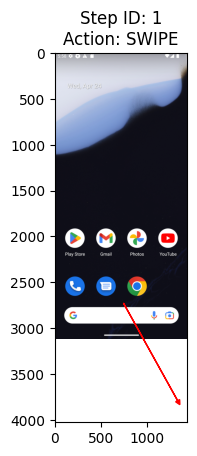

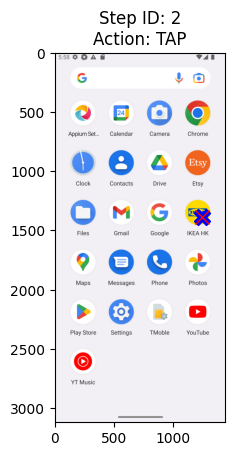

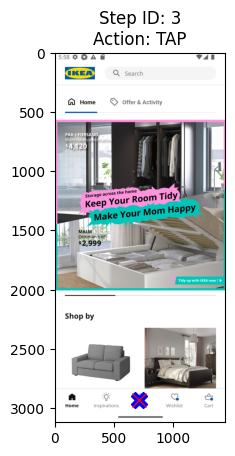

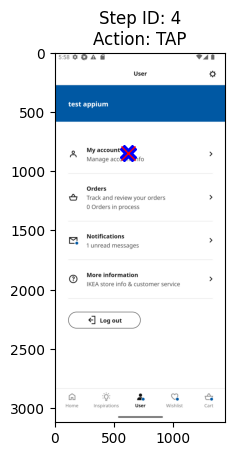

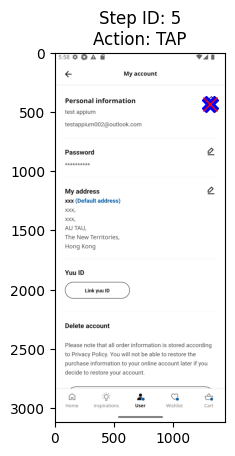

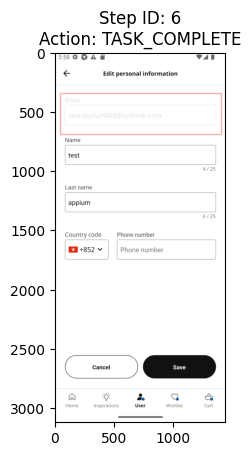

In [124]:
eps_id = "dfac0e5bd90b4250b04c815b406fba90"
for task in task_data:
    if task['episode_id'] == eps_id:
        plot_instruction_data(task)
        break

Episode:  9dc59983c64345f2a8789a4780dbe576 step number:  21
Instruction:  Open Wego. Search hotels in Dubai, from 25 December to 31 December. 2 guests in 1 room. Five stars. Sort by guest rating. Search by name Burj Al Arab.


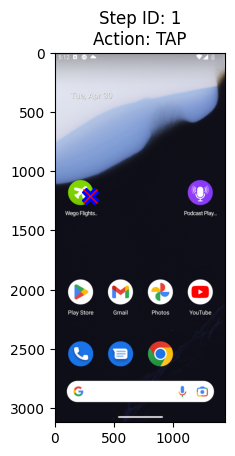

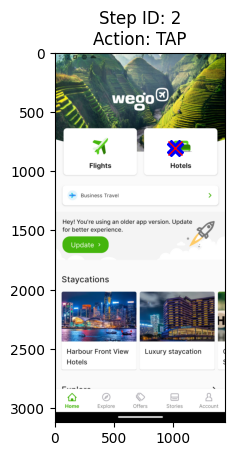

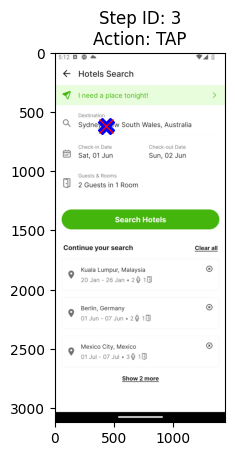

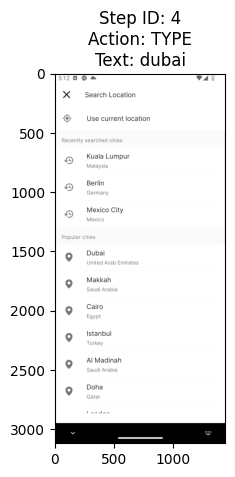

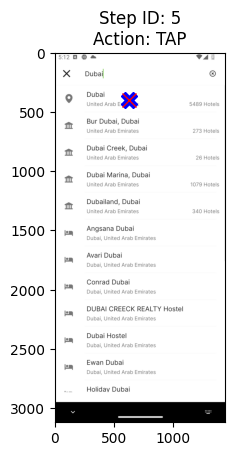

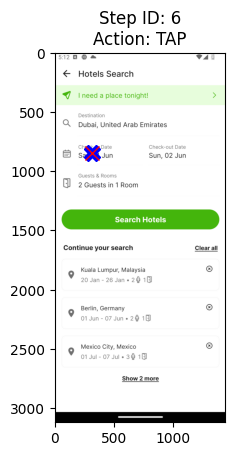

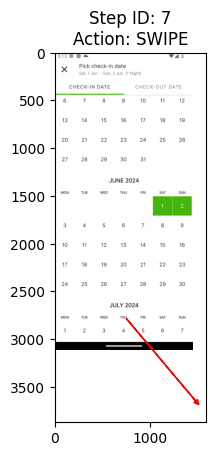

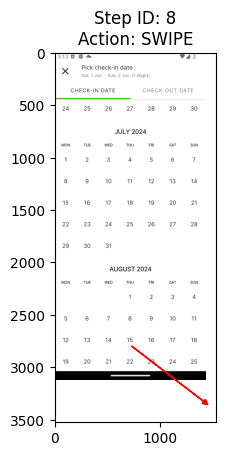

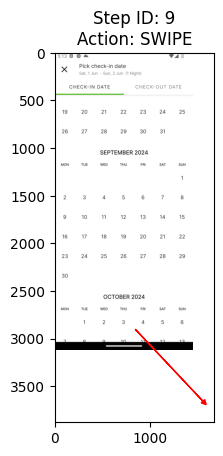

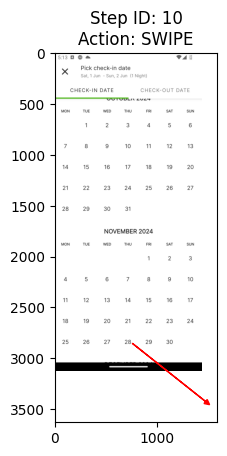

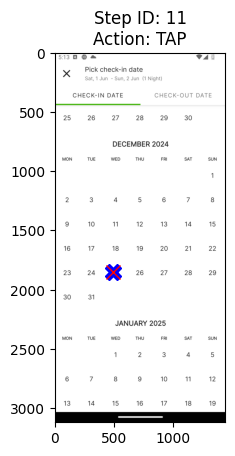

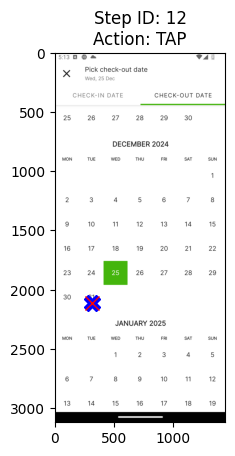

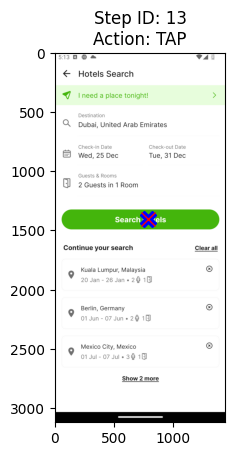

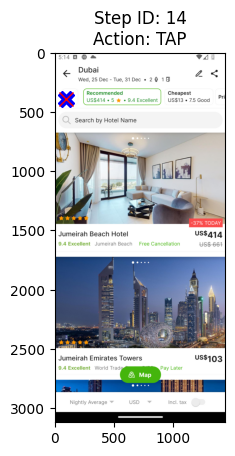

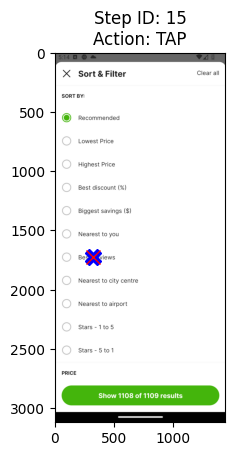

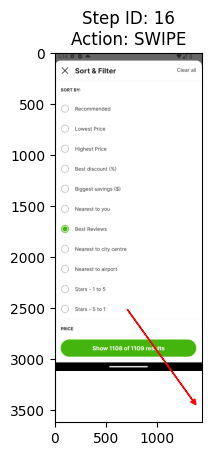

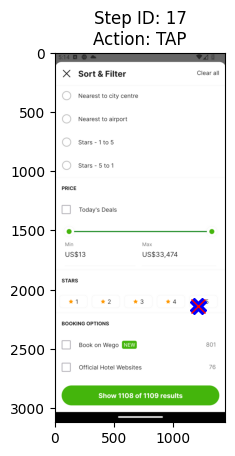

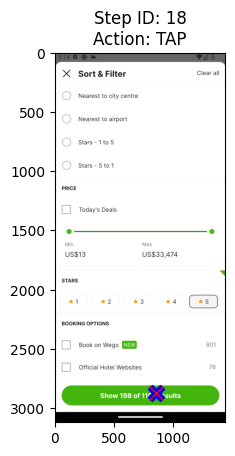

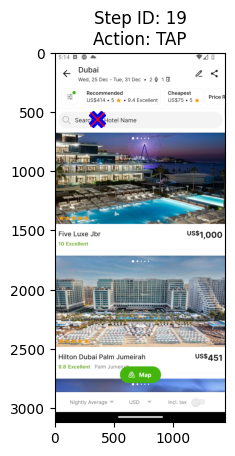

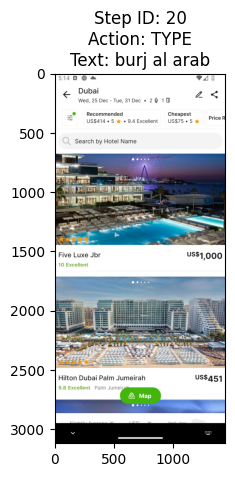

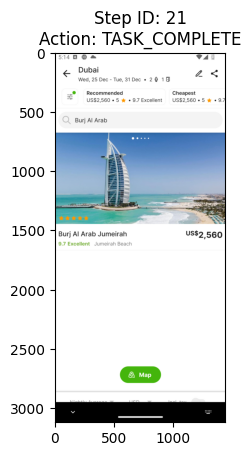

In [5]:
plot_instruction_data(random.choice(task_data))

In [37]:
action_distribution = {}
for task in task_data:
    for step in task['steps']:
        if step['action'] not in action_distribution:
            print(step)
        action_distribution[step['action']] = action_distribution.get(step['action'], 0) + 1

action_distribution

{'step_id': 1, 'action': 'SWIPE', 'touch_coord': [769, 2004], 'lift_coord': [769, 962], 'device_dim': [1440, 2960], 'package_name': 'com.android.launcher3', 'type_text': '', 'need_human_check': False, 'interest_region': [[0, 0], [0, 0]], 'image_path': '2024_4_26_14_33_b0c1f08e53664926952ccc066864f075-1.png', 'element_data': {'image_path': '2024_4_26_14_33_b0c1f08e53664926952ccc066864f075-1.png', 'clickable_elements': [{'bbox': [53, 276, 197, 420], 'xml_desc': [], 'functionality': ''}, {'bbox': [197, 283, 1373, 413], 'xml_desc': [], 'functionality': ''}, {'bbox': [303, 2060, 581, 2549], 'xml_desc': ['Gallery', 'Gallery'], 'functionality': ''}, {'bbox': [581, 2060, 859, 2549], 'xml_desc': ['Chrome', 'Chrome'], 'functionality': ''}, {'bbox': [859, 2060, 1137, 2549], 'xml_desc': ['Play Store', 'Play Store'], 'functionality': ''}, {'bbox': [25, 2624, 303, 2813], 'xml_desc': ['Phone', 'Phone'], 'functionality': ''}, {'bbox': [303, 2624, 581, 2813], 'xml_desc': ['Messaging', 'Messaging'], 'fu

{'SWIPE': 7628,
 'TAP': 24815,
 'TYPE': 2419,
 'TASK_COMPLETE': 2828,
 'PRESS_ENTER': 651,
 'TASK_IMPOSSIBLE': 220,
 'PRESS_BACK': 135,
 'PRESS_HOME': 13}

In [7]:
a = random.choice(element_data)
for k,v in a.items():
    print(k, type(v))


page_caption <class 'str'>
image_path <class 'str'>
clickable_elements <class 'list'>
scrollable_elements <class 'list'>


In [40]:
random.choice(task_data)

{'instruction': 'I want to read the news about "Moscow attack" at the home page in NBC NEWS, copy the share link and open the news in Chrome.',
 'episode_id': '917ac13d323e4980abbd6ebeda523ccc',
 'steps': [{'step_id': 1,
   'action': 'TAP',
   'touch_coord': [1230, 2577],
   'lift_coord': [1230, 2577],
   'device_dim': [1440, 3120],
   'package_name': 'com.google.android.apps.nexuslauncher',
   'type_text': '',
   'need_human_check': False,
   'interest_region': [[0, 0], [0, 0]],
   'image_path': '2024_3_24_2_11_917ac13d323e4980abbd6ebeda523ccc-1.png',
   'element_data': {'page_caption': 'The screenshot shows the home screen of an Android mobile phone, featuring various app icons and a search bar.',
    'image_path': '2024_3_24_2_11_917ac13d323e4980abbd6ebeda523ccc-1.png',
    'clickable_elements': [{'bbox': [132, 327, 1364, 409],
      'xml_desc': ['Sun, Mar 24', 'Sun, Mar 24'],
      'functionality': ''},
     {'bbox': [76, 1886, 356, 2249],
      'xml_desc': ['Play Store', 'Play Sto